## Support Vector Machine

                    - From scratch 

In [2]:
# svm.py
import numpy as np  # for handling multi-dimensional array operation
import pandas as pd  # for reading data from csv 
import statsmodels.api as sm  # for finding the p-value
from sklearn.preprocessing import MinMaxScaler  # for normalization
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle


In [22]:
def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('../Data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]


    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)
    return X,Y

In [23]:
def train(X_train,X_test, y_train, y_test):  
    # train the model
    print("training started...")
    W = sgd(X_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(W))
    
    # testing the model
    print("testing the model...")
    y_train_predicted = predict(X_train,W)
    y_test_predicted = predict(X_test, W)
    
    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    
    return W

In [24]:
def predict(X,W):  
    y_predicted = np.array([])
    
    for i in range(X.shape[0]):
        yp = np.sign(np.dot(X.to_numpy()[i], W))
        y_predicted = np.append(y_predicted, yp)
    return y_predicted
    
    

Intercept is added to each sample so that we can perform matrix operations directly
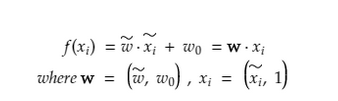

#### COST FUNCTION
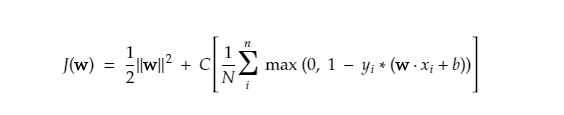

In [25]:
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

Gradient of the cost function
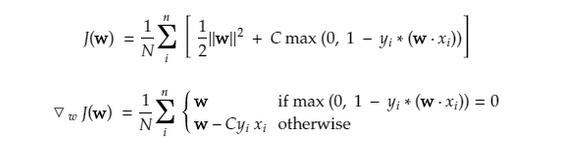

In [26]:
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw



In [27]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

In [28]:
regularization_strength = 10000 # regularization strength
learning_rate = 0.000001

X,Y= init()
X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)
W=train(X_train, X_test, y_train, y_test)

reading dataset...
applying feature engineering...
training started...
Epoch is: 1 and Cost is: 5287.183776009597
Epoch is: 2 and Cost is: 3345.3777360661143
Epoch is: 4 and Cost is: 2451.875258013311
Epoch is: 8 and Cost is: 1910.8025617973333
Epoch is: 16 and Cost is: 1532.9276725982572
Epoch is: 32 and Cost is: 1215.2438223476906
Epoch is: 64 and Cost is: 960.6042683259784
Epoch is: 128 and Cost is: 816.4225588742429
Epoch is: 256 and Cost is: 702.4942507044424
Epoch is: 512 and Cost is: 646.4823654486308
Epoch is: 1024 and Cost is: 622.153414636899
Epoch is: 2048 and Cost is: 610.5553483507041
Epoch is: 4096 and Cost is: 605.3248475873181
training finished.
weights are: [ 1.28998866  0.9016343   1.10435185  2.16770395 -1.21314882 -3.13592208
  3.30669177  6.70470475 -0.47605319  0.02574668  5.60547799 -1.87372278
  3.27863425  3.70358096  1.65492476 -2.41529824 -1.69471358  0.70852412
 -1.91944699 -1.76258562  2.74049297  5.27413926  1.15699657  3.09255263
  2.25175699 -0.67491566 

### Visualization

In [29]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components=2
pca=pca.fit(X)

In [30]:
W_rowVec= W.reshape(-1, 1).T
X_W= np.vstack((X, W_rowVec))

In [31]:
X.shape, X_W.shape, W_rowVec.shape

((569, 31), (570, 31), (1, 31))

In [32]:
pca_X_W= pca.transform(X_W)

In [33]:
X_pca_data= pca_X_W[:-1, :]
X_pca_data.shape

(569, 2)

In [34]:
W_pca_data = pca_X_W[-1,:]
W_pca_data.shape

(2,)

In [35]:
import seaborn as sn
import matplotlib.pyplot as plt 

In [55]:
def abline(W_pca_data):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array([1,-0.5])
    y_vals = -W_pca_data[0] * x_vals /W_pca_data[1]
    plt.plot(x_vals, y_vals)

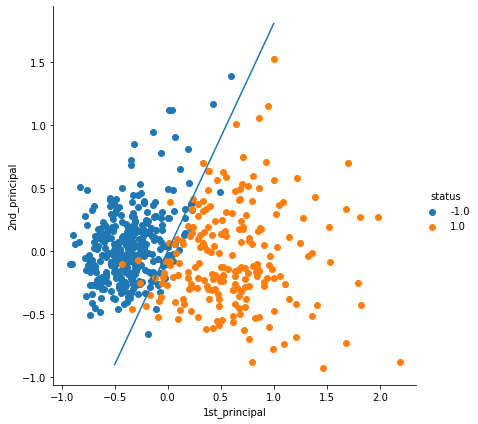

In [56]:
pca_data = np.vstack((X_pca_data.T, Y)).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "status"))
sn.FacetGrid(pca_df, hue="status", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
abline(W_pca_data)
plt.show()
